# REF: 
<br>https://phamdinhkhanh.github.io/2019/12/12/ARIMAmodel.html
<br>https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

# <span style='color:Green'>Background</span>
In this project, i'll run through an example of coffee price forecasting using **<span style='color:Green'>SARIMA (Seasonal Autoregressive Integrated Moving Average)</span>** model. The data is collected in VietNam from 01-2021 to 04-2023. The model will look back at 60 days in the dataset and predict the next 30 days for the coffee price, then the effectiveness will be meaesured using RMSE / MAPE (mean absolute percentage error). <b>The following topics will be covered:
- <b>Stationarity (Differencing and Augmented Dickey-Fuller Test)
- <b>ACF and PACF Plots
- <b>Grid Search and AIC
- <b>Walk Forward Validation
- <b>MAPE
- <b>Exogenous Variables</b>

# <span style='color:Green'>  Import Libraries </span>

In [1]:
# Data Handling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
import tensorflow as tf
import sklearn

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Feature Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Other Packages
import warnings
warnings.filterwarnings("ignore")

# <span style='color:Green'>  EDA & Visualizing </span>

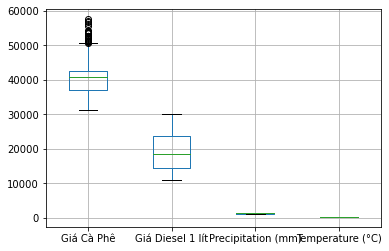

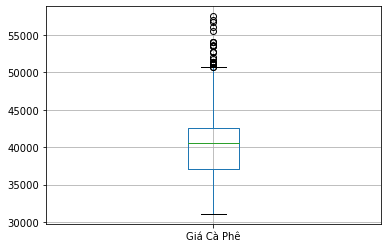

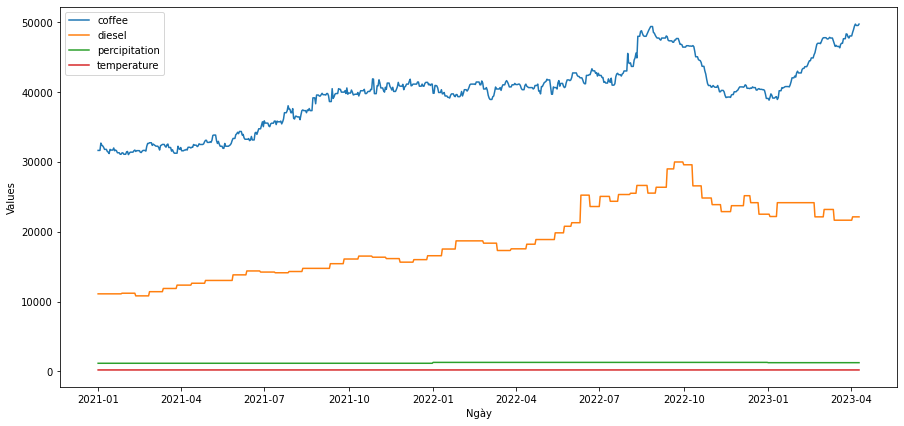

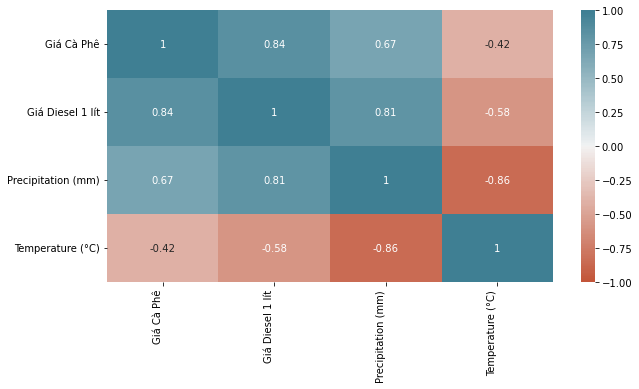

Stored 'data' (DataFrame)
Stored 'look_back' (int)
Stored 'predict_ahead' (int)


In [2]:
%run Data.ipynb

# <span style='color:Green'> ---------- Retrieve Data ----------- </span>

In [3]:
%store -r data
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm),Temperature (°C)
0,2021-01-01,31667.5,11120.0,1174.199994,217.0
1,2021-01-02,31667.5,11120.0,1174.199994,217.0
2,2021-01-03,31667.5,11120.0,1174.199994,217.0
3,2021-01-04,32717.0,11120.0,1174.199994,217.0
4,2021-01-05,32417.0,11120.0,1174.199994,217.0
...,...,...,...,...,...
825,2023-04-06,49766.5,22150.0,1259.800013,218.0
826,2023-04-07,49566.5,22150.0,1259.800013,218.0
827,2023-04-08,49566.5,22150.0,1259.800013,218.0
828,2023-04-09,49566.5,22150.0,1259.800013,218.0


In [4]:
# take coffee price only
data.drop(data.columns[[-1, -2, -3]], axis=1, inplace=True)

In [5]:
data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


In [6]:
# Lưu data gốc dưới tên sau
original_data = data.copy()

#   --------- Normalization ( Xử lý, biến đổi dữ liệu) ---------- 

# ---- Phân tích chuỗi thời gian ----

The EDA above that the data contains a periodic component, so transformations will need to be applied to make the data stationary. In this case, we’ll apply both a first difference and weekly seasonal difference.

Ta áp dụng Sai phân (differencing) để biến đổi chuỗi thời gian ban đầu thành chuỗi dừng (stationary series).
<br>-> Chuỗi dừng có thể giúp trong việc loại bỏ yếu tố mùa vụ và làm cho dữ liệu ổn định hơn để áp dụng mô hình SARIMA hoặc ARIMA.
### Trong trường hợp 1, ta sẽ biến đổi 'reframed' thành chuỗi dừng và xây dựng model ARIMA (loại bỏ yếu tố mùa vụ)

Ta sẽ chuyển chuỗi giá sang chuỗi dừng bằng cách lấy lợi suất theo công thức sai phân bậc 1 của logarit, hoặc sai phân bậc 1 thông thường 

### Kiểm tra tính dừng


In [7]:
coffee_prices = original_data['Giá Cà Phê']

# Apply the ADF test to the coffee prices
result_diff = adfuller(coffee_prices)

# Print the ADF test results for 'Gia Ca Phe'
print(f'ADF Statistic for Gia Ca Phe: {result_diff[0]}')
print(f'p-value for Gia Ca Phe: {result_diff[1]}')

if result_diff[1] <= 0.05:
    print('Time series Gia Ca Phe is STATIONARY')
else:
    print('Time series Gia Ca Phe is NOT STATIONARY')

ADF Statistic for Gia Ca Phe: -0.7084086200654476
p-value for Gia Ca Phe: 0.84455947670186
Time series Gia Ca Phe is NOT STATIONARY


In [8]:
original_data_diff = original_data.diff().dropna()

In [9]:
original_data_diff

,Ngày,Giá Cà Phê
1,1 days,0.0
2,1 days,0.0
3,1 days,1049.5
4,1 days,-300.0
5,1 days,-100.0
...,...,...
825,1 days,300.0
826,1 days,-200.0
827,1 days,0.0
828,1 days,0.0


<u>Nhận xét: 
+ Một số giá trị bằng 0 tại vì có các giá trị giống nhau liên tiếp
+ Các giá trị đầu tiên sau khi áp dụng sai phân sẽ trở thành NaN. Điều này xảy ra vì không có giá trị trước đó để lấy hiệu (difference) với giá trị đầu tiên. (nhưng ta đã loại bỏ NaN trong bảng)

In [10]:
# Apply the ADF test to the coffee prices
result_diff = adfuller(original_data_diff['Giá Cà Phê'])

# Print the ADF test results for 'Gia Ca Phe'
print(f'ADF Statistic for Gia Ca Phe after differencing: {result_diff[0]}')
print(f'p-value for Gia Ca Phe after differencing: {result_diff[1]}')

if result_diff[1] <= 0.05:
    print('Time series Gia Ca Phe is STATIONARY after differencing')
else:
    print('Time series Gia Ca Phe is NOT STATIONARY after differencing')

ADF Statistic for Gia Ca Phe after differencing: -30.68566095530477
p-value for Gia Ca Phe after differencing: 0.0
Time series Gia Ca Phe is STATIONARY after differencing


## Hoặc ta có thể bỏ qua bước này (thay thế bởi cell thứ  ) là tiến hành differencing ngay trong function auto_arima với giá trị 'd=1' Di chuyển đến cell thứ 18

Việc vẫn để những cell từ đây, để ta có thể include những technique khác như Double Exponential Smoothing (DES), Trend-adjusted Exponential Smoothing, and Holt's Exponential Smoothing giống với cách áp dụng cho cell 8

## Kiểm tra yếu tố mùa vụ -> Xem có nên dùng SARIMA làm model hay chỉ cần là ARIMA

In [11]:
original_data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


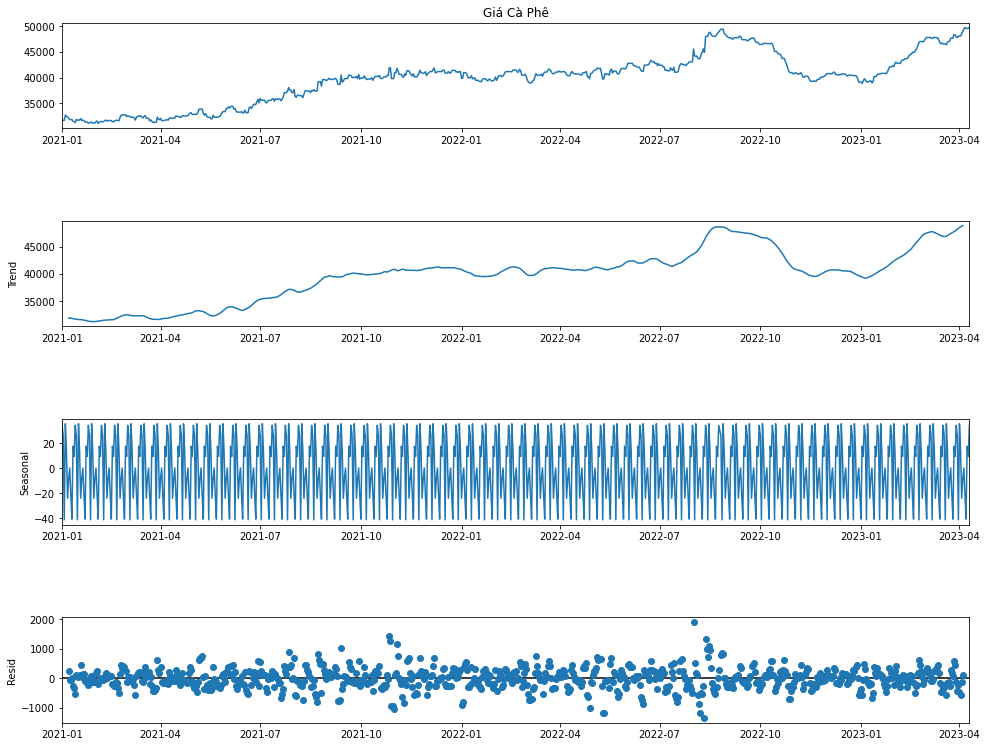

In [12]:
# dùng seasonal_decompose để phân tích các thành phần (observed, trend, seasonal, residual) 
result = seasonal_decompose(original_data['Giá Cà Phê'], period=12) 
result.observed.index = original_data['Ngày']
result.trend.index = original_data['Ngày']
result.seasonal.index = original_data['Ngày']
result.resid.index = original_data['Ngày']

fig = result.plot()
fig.set_size_inches(16, 12)
plt.show()

<u>Nhận xét: 
+ lag 7 (s = 7), có thể xuất hiện các giá trị âm trong dữ liệu sai phân mới (reframed_seasonal_diff). Điều này xảy ra khi giá trị hiện tại được trừ đi giá trị của chu kỳ mùa vụ tương ứng cách đó 7 bước thời gian. Khi chu kỳ mùa vụ ảnh hưởng tiêu cực lên giá trị hiện tại, sai phân sẽ tạo ra các giá trị âm.

In [13]:
# Type "nbsp" to add a single space.
# Type "ensp" to add 2 spaces.
# Type "emsp" to add 4 spaces.
# Use the non-breaking space (nbsp) 4 times to insert a tab.
# eg. &emsp;This is an example.

# ---------- Split data  ----------
### For ARIMA

In [14]:
original_data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


In [15]:
# index date column
original_data['Ngày'] = pd.to_datetime(original_data['Ngày'])
original_data.set_index('Ngày', inplace=True)

# Split the data into training (70%) and testing (30%)
train_size = 0.7
test_size = 0.3

train_data, test_data = train_test_split(original_data, 
                                         shuffle=False,  # Maintain time order
                                         train_size=train_size, 
                                         test_size=test_size)
# Print the shapes of the resulting data
print('Training data:', train_data.shape)
print('Testing data:', test_data.shape)

Training data: (580, 1)
Testing data: (249, 1)


In [16]:
train_data

,Giá Cà Phê
Ngày,
2021-01-01,31667.50
2021-01-02,31667.50
2021-01-03,31667.50
2021-01-04,32717.00
2021-01-05,32417.00
...,...
2022-07-30,43050.00
2022-07-31,43050.00
2022-08-01,45567.25


# ---------- Xây dựng model và dự đoán -----------

## 1. Xây dựng model ARIMA 
### &nbsp; 1.a Lựa chọn tham số (p, d, q)(P, D, Q, s)
#### &ensp; <font color="green">1.a.1. ACF và PACF</font>


- <b>Tự tương quan (ACF - AutoCorrelation Function):</b> là  khái niệm quan trọng trong chuỗi thời gian. Hầu hết các chuỗi thời gian sẽ có sự tương quan với <b>giá trị trễ của nó</b> và <b>các giá trị càng gần nhau</b> thì tương quan càng mạnh hoặc các giá trị cùng thuộc 1 chu kì của chuỗi thì sẽ có tương quan cao (chẳng hạn như cùng tháng trong chu kì năm hay cùng quí trong chu kì năm). <br>
<br>
- <b> Tự tương quan riêng phần (PACF - Partitial AutoCorrelation Function):</b> Về cơ bản tương quan riêng phần cũng là chỉ số đo lường hệ số tương quan như ACF. Tuy nhiên vẫn có sự khác biệt đó là hệ số tương quan này loại bỏ ảnh hưởng của các chuỗi độ trễ trung gian

<u>Nhận xét:</u> Trục hoành là độ trễ, trục tung là giá trị của hệ số tự tương quan tương ứng với độ trễ. Dải màu xanh chính là khoảng tin cậy 95% để giá trị hệ số tự tương quan bằng 0.<br>
<br><u> Đối với mô hình ARIMA (p, d, q):

+ p (bậc của AR): Xem đỉnh trên đồ thị PACF. Nếu có một đỉnh đột biến sau một số lượng lag cụ thể và giảm xuống 0 sau đó, chọn p là số lag đó. -> p = 1
+ d (bậc của sai phân): Xem xem có cần sai phân để làm cho chuỗi dừng. Nếu cần, chọn d là số lần sai phân cần thiết -> d = 1
+ q (bậc của MA): Xem đỉnh trên đồ thị ACF. Nếu có một đỉnh đột biến sau một số lượng lag cụ thể và giảm xuống 0 sau đó, chọn q là số lag đó -> q = 1

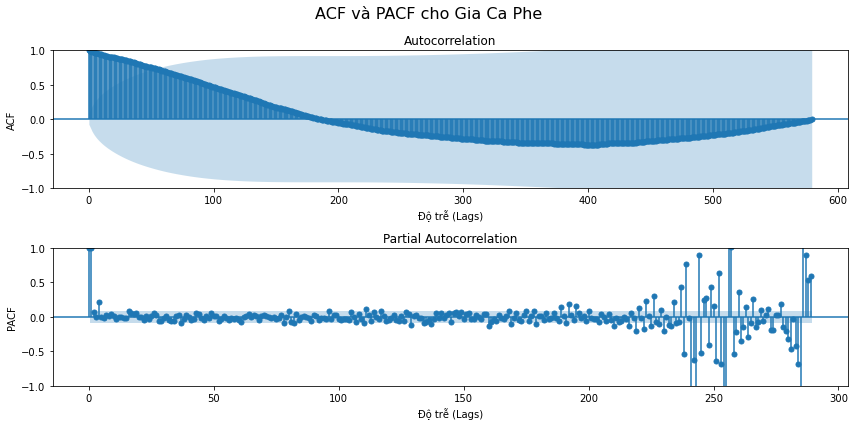

In [17]:
plt.figure(figsize=(12, 6))
plt.suptitle(f'ACF và PACF cho Gia Ca Phe', fontsize=16)
    
# Vẽ ACF
plt.subplot(2, 1, 1)
plot_acf(train_data.dropna(), lags=579, ax=plt.gca())
plt.xlabel('Độ trễ (Lags)')
plt.ylabel('ACF')
    
# Vẽ PACF
plt.subplot(2, 1, 2)
plot_pacf(train_data.dropna(), lags=289, ax=plt.gca())
plt.xlabel('Độ trễ (Lags)')
plt.ylabel('PACF')
    
plt.tight_layout()
plt.show()

<u>Nhận xét: 
+ p and P both equal 1 (positive spikes in ACF and PACF plots)
+ d and D both equal 1 (first difference and seasonal difference)
+ q and Q both equal 1 (significant negative spikes, PACF decay is more gradual)

####  &ensp; 1.a.2 Phương pháp auto_arima dành cho ARIMA (ta sẽ tiếp tục phương pháp khác cho model chính SARIMA)
Ở đây các thông số p,d,q là parameters cho model ARIMA của ta, với 'd=1' là mặc định, ta sẽ differencing thay vì làm như cell thứ 11 

In [18]:
from pmdarima import auto_arima
model = auto_arima(train_data, start_p=0, start_q=0,
                           max_p=5, max_q=5, max_d=5, 
                           seasonal=False,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# Print the model summary
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8568.382, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8561.863, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8559.952, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8568.102, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8551.685, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8552.769, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8552.430, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8556.333, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8557.695, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8556.379, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.056 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  580
M

In [19]:
# Model fitting
from statsmodels.tsa.arima.model import ARIMA

# Replace with our best params
p, d, q = 1, 1, 1

# Create and fit the ARIMA model
arima_model = ARIMA(train_data, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Print model summary
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Giá Cà Phê   No. Observations:                  580
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4275.189
Date:                Wed, 27 Sep 2023   AIC                           8556.379
Time:                        02:11:28   BIC                           8569.463
Sample:                    01-01-2021   HQIC                          8561.480
                         - 08-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6274      0.122      5.122      0.000       0.387       0.867
ma.L1         -0.7524      0.106     -7.131      0.000      -0.959      -0.546
sigma2      1.499e+05   4438.197     33.770      0.0

####  &ensp; 1.a.3 Phương pháp grid search cho SARIMA (model chính)

In [20]:
import itertools
import numpy as np

# Set parameter range
p = range(0, 3)
q = range(1, 3)
d = range(1, 2) #differencing
s = range(7, 12) #seasonal 

# List of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

# Initialize variables to keep track of the best model and AIC score
best_aic = np.inf  # Initialize with a high value
best_model = None

# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                          order=param,
                                          seasonal_order=param_seasonal)
            results = mod.fit(max_iter=50, method='powell')
            aic = results.aic
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, aic))

            # Update the best model and AIC score if a better one is found
            if aic < best_aic:
                best_aic = aic
                best_model = (param, param_seasonal)
        except:
            continue

# Print the best model and its AIC score
print('\nBest Model:')
print(f'SARIMA{best_model[0]},{best_model[1]} - AIC:{best_aic}')

Optimization terminated successfully.
         Current function value: 7.369470
         Iterations: 3
         Function evaluations: 114
SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:8554.584702375909
Optimization terminated successfully.
         Current function value: 7.369171
         Iterations: 3
         Function evaluations: 108
SARIMA(0, 1, 1),(0, 1, 1, 8) - AIC:8554.238326011531
Optimization terminated successfully.
         Current function value: 7.353022
         Iterations: 3
         Function evaluations: 111
SARIMA(0, 1, 1),(0, 1, 1, 9) - AIC:8535.505635432439
Optimization terminated successfully.
         Current function value: 7.345690
         Iterations: 3
         Function evaluations: 114
SARIMA(0, 1, 1),(0, 1, 1, 10) - AIC:8527.000263698035
Optimization terminated successfully.
         Current function value: 7.343413
         Iterations: 3
         Function evaluations: 111
SARIMA(0, 1, 1),(0, 1, 1, 11) - AIC:8524.358780881541
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 7.332219
         Iterations: 4
         Function evaluations: 228
SARIMA(0, 1, 2),(1, 1, 1, 10) - AIC:8515.373821739962
Optimization terminated successfully.
         Current function value: 7.326229
         Iterations: 4
         Function evaluations: 248
SARIMA(0, 1, 2),(1, 1, 1, 11) - AIC:8508.425335583011
Optimization terminated successfully.
         Current function value: 7.361813
         Iterations: 4
         Function evaluations: 285
SARIMA(0, 1, 2),(1, 1, 2, 7) - AIC:8551.703146086198
Optimization terminated successfully.
         Current function value: 7.364223
         Iterations: 4
         Function evaluations: 274
SARIMA(0, 1, 2),(1, 1, 2, 8) - AIC:8554.498556417608
Optimization terminated successfully.
         Current function value: 7.337255
         Iterations: 3
         Function evaluations: 210
SARIMA(0, 1, 2),(1, 1, 2, 9) - AIC:8523.216053098175
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 7.369656
         Iterations: 4
         Function evaluations: 324
SARIMA(1, 1, 1),(2, 1, 2, 8) - AIC:8562.801263632206
Optimization terminated successfully.
         Current function value: 7.342356
         Iterations: 4
         Function evaluations: 326
SARIMA(1, 1, 1),(2, 1, 2, 9) - AIC:8531.133463422157
Optimization terminated successfully.
         Current function value: 7.330842
         Iterations: 4
         Function evaluations: 343
SARIMA(1, 1, 1),(2, 1, 2, 10) - AIC:8517.777041476593
Optimization terminated successfully.
         Current function value: 7.319687
         Iterations: 5
         Function evaluations: 427
SARIMA(1, 1, 1),(2, 1, 2, 11) - AIC:8504.836924010118
Optimization terminated successfully.
         Current function value: 7.363450
         Iterations: 3
         Function evaluations: 187
SARIMA(1, 1, 2),(0, 1, 1, 7) - AIC:8551.601898451843
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 7.324021
         Iterations: 3
         Function evaluations: 215
SARIMA(2, 1, 1),(0, 1, 2, 11) - AIC:8507.864937575057
Optimization terminated successfully.
         Current function value: 7.362874
         Iterations: 4
         Function evaluations: 291
SARIMA(2, 1, 1),(1, 1, 1, 7) - AIC:8552.933514286517
Optimization terminated successfully.
         Current function value: 7.365635
         Iterations: 4
         Function evaluations: 262
SARIMA(2, 1, 1),(1, 1, 1, 8) - AIC:8556.137029293852
Optimization terminated successfully.
         Current function value: 7.338047
         Iterations: 4
         Function evaluations: 271
SARIMA(2, 1, 1),(1, 1, 1, 9) - AIC:8524.133991586594
Optimization terminated successfully.
         Current function value: 7.333895
         Iterations: 4
         Function evaluations: 290
SARIMA(2, 1, 1),(1, 1, 1, 10) - AIC:8519.318508939476
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 7.335060
         Iterations: 9
         Function evaluations: 847
SARIMA(2, 1, 2),(2, 1, 1, 9) - AIC:8524.669971724728
Optimization terminated successfully.
         Current function value: 7.329381
         Iterations: 5
         Function evaluations: 459
SARIMA(2, 1, 2),(2, 1, 1, 10) - AIC:8518.082488448093
Optimization terminated successfully.
         Current function value: 7.324514
         Iterations: 8
         Function evaluations: 766
SARIMA(2, 1, 2),(2, 1, 1, 11) - AIC:8512.43606099534
Optimization terminated successfully.
         Current function value: 7.361771
         Iterations: 5
         Function evaluations: 540
SARIMA(2, 1, 2),(2, 1, 2, 7) - AIC:8557.654485186287
Optimization terminated successfully.
         Current function value: 7.363200
         Iterations: 4
         Function evaluations: 430
SARIMA(2, 1, 2),(2, 1, 2, 8) - AIC:8559.311549657461
Optimization terminated successfully.
      

"Best Model:
SARIMA(1, 1, 1),(0, 1, 2, 11) - AIC:8503.874420740969" <br>Using these parameters, the model was fit to the data, and then a new set of ACF and PACF plots of the model’s residuals was evaluated. See the code below:

Optimization terminated successfully.
         Current function value: 7.322306
         Iterations: 4
         Function evaluations: 238


<Figure size 864x432 with 0 Axes>

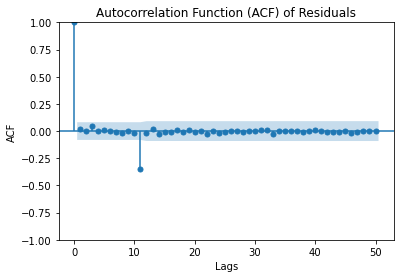

<Figure size 864x432 with 0 Axes>

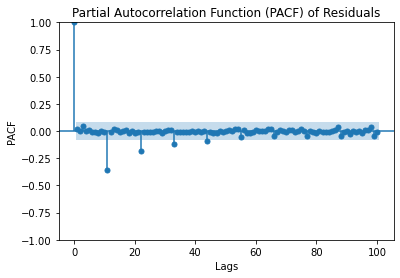

In [21]:
model = sm.tsa.statespace.SARIMAX(train_data, 
                                  order=(1, 1, 1), 
                                  seasonal_order=(0, 1, 2, 11)).fit(max_iter=50, method='powell')

res = model.resid
# Plot ACF
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(res, lags=50)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(res, lags=100)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()


<u>Nhận xét: 
+ In ACF and PACF, significant spikes at lag 11, 22, 33, 44

+ s equal to 11 (weekly seasonal component)
    
+ These parameters are an acceptable starting point for the model

### &nbsp; 1.b Walk Forward Validation & Evaluation with MAPE & RMSE
While a simple train/test split is possible for time series, a more robust option is walk forward validation in which the test data is split up multiple times. <br> In the first walk through, daily loads for the first 11 days of the actual data are predicted based on the model fit to the training data. In the second walk through, the actual daily loads for the first 11 days of actual data are added to the training data, the model is refit, and loads for the next 11 days are predicted. The same process is followed for the third,fourth, and so on 11 days until at the end of test_data

In [22]:
# train_data.shape (580, 1)
# test_data.shape (249,1)

# data = entire dataset
# n_test = point where data is split into training and test sets

def walk_forward_validation(data, n_test):
    predictions = np.array([])
    mape_list = []
    train, test = data[:n_test], data[n_test:]
    total_test_values = len(test)
    day_list = [11, 22, 33, 44]

    for i in range(0, total_test_values, 11):
        # Fit model to training data
        model = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 2, 11)).fit(max_iter=50, method='powell')
        
        # Forecast daily loads for the next 11 days
        start_idx = i
        end_idx = min(i + 11, total_test_values)  # Ensure we don't go beyond the test set
        forecast = model.get_forecast(steps=end_idx - start_idx).predicted_mean
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        mape_score = (np.abs(test[start_idx:end_idx] - forecast[:end_idx-start_idx]) / test[start_idx:end_idx]) * 100
        mape_mean = mape_score.mean()
        mape_list.append(mape_mean)

        # Update the training set for the next iteration
        train = np.concatenate((train, test[start_idx:end_idx]), axis=None)
    
    return predictions, mape_list

In [23]:
# Usage
predictions, mape_list = walk_forward_validation(original_data['Giá Cà Phê'].values, 580)

Optimization terminated successfully.
         Current function value: 7.322306
         Iterations: 4
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 7.365162
         Iterations: 3
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 7.366263
         Iterations: 3
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 7.363387
         Iterations: 3
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: 7.358059
         Iterations: 3
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 7.353247
         Iterations: 3
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 7.346432
         Iterations: 3
         Function evaluations: 189
Optimization terminated successful

In [24]:
print(mape_list)

[3.2086270921958584, 1.804562999374511, 2.5332274839201006, 0.6579142819122593, 0.6105525805655198, 1.0398817631153223, 2.9838960482052386, 5.130657390819332, 0.661280683388617, 2.0175923513305474, 1.9832093373617554, 0.7815179533819852, 0.4125770854607959, 2.204215655186649, 1.1779996490018632, 0.8341271474498335, 1.3394066087768215, 1.6266775935869924, 3.1556874454824753, 0.5377313123206814, 2.251939634786723, 2.3855944521531125, 1.604154702543123]


In [25]:
# Calculate the MAPE
average_mape = np.mean(mape_list)
print(f"Mean Absolute Percentage Error (MAPE): {average_mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 1.78%


In [26]:
predictions

array([43962.67784485, 43845.6717263 , 43839.55040353, 43862.23016012,
       43868.24678173, 43908.91971748, 43890.08696042, 43888.62667413,
       44386.23063091, 44151.26677245, 44130.36572208, 47728.2396927 ,
       47430.36803006, 47232.63589188, 47167.47995015, 47299.72018437,
       47368.38597184, 47561.42348795, 47409.95770041, 48164.14529682,
       48200.23622399, 48179.43401819, 49473.93473601, 49482.04757931,
       49342.2735795 , 49306.02694537, 49239.91117247, 49283.38987131,
       49294.14933623, 49420.11652978, 49522.7576355 , 49574.46427921,
       49690.44466069, 47478.66841003, 47528.17225934, 47353.78473037,
       47415.76941471, 47380.32661308, 47408.71162616, 47430.66398835,
       47442.5635391 , 47600.87278883, 47547.89974085, 47515.69432147,
       47434.76661352, 47463.60984672, 47472.76231621, 47531.64906241,
       47549.49151174, 47699.79801346, 47727.14502248, 47642.3938008 ,
       47752.57460231, 47765.07406069, 47786.96842827, 46884.46333934,
      

In [27]:
len(predictions) # prediction is the first 44 days of the test dataset

249

In [28]:
# get the actual data
#actual_data = test_data.iloc[:44].values
actual_data = test_data.values

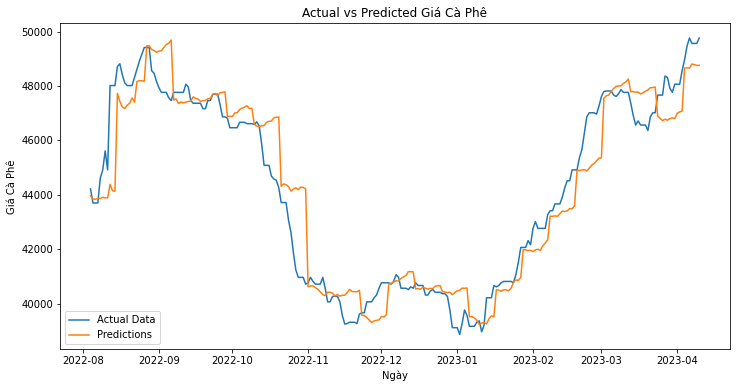

In [29]:
# Create an index
dates = test_data.index

# Plot actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_data, label='Actual Data')
plt.plot(dates, predictions, label='Predictions')
plt.xlabel('Ngày')
plt.ylabel('Giá Cà Phê')
plt.title('Actual vs Predicted Giá Cà Phê')
plt.legend()
plt.show()

In [30]:
# Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_data, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_data, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} (đồng)")

Mean Absolute Percentage Error (MAPE): 8.76%
Root Mean Squared Error (RMSE): 1086.39 (đồng)


In [31]:
predictions[-1:] #last predictions day

array([48761.75069687])

In [32]:
test_data.tail(1)

,Giá Cà Phê
Ngày,
2023-04-10,49766.5


In [33]:
# ver2 ???
# Create a list starting from 11 and incrementing by 11 up to test_data number of values
def generate_day_list(increment_by, max_value):
    day_list = []
    i = increment_by
    while i <= max_value:
        day_list.append(i)
        i += increment_by
    
#     if day_list[-1] < max_value:
#         day_list.append(day_list[-1] + increment_by)
    
    return day_list

# increment of 11 up to 249
day_list = generate_day_list(increment_by=11, max_value=249) # 249 test_data

#
print(day_list)

[11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154, 165, 176, 187, 198, 209, 220, 231, 242]


In [34]:
# data = entire dataset
# n_test = point where data is split into training and test sets
def walk_forward_validation_v2(data, n_test):
    predictions = np.array([])
    mape_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = generate_day_list(increment_by=11, max_value=249) # 249 test_data
    for i in day_list:
        # Fit model to training data
        model = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 2, 11)).fit(max_iter=50, method='powell')
        
        # Forecast daily loads for i phase of 11 days (next 11 days)
        forecast = model.get_forecast(steps=11).predicted_mean
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i - 11
        mape_score = (np.abs(test[j:i] - forecast) / test[j:i]) * 100  # Calculate MAPE
        mape_mean = mape_score.mean()
        mape_list.append(mape_mean)
        
        # Add phase i of 11 days to training data for the next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, mape_list